In [2]:
import pandas as pd
import numpy as np
import tqdm
from tqdm import tqdm_notebook
import difflib
import sys
import re
from matplotlib import pyplot as plt
import matplotlib

import ast
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from functools import reduce
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder, BigramAssocMeasures, TrigramAssocMeasures

import pymorphy2 as pm
morph = pm.MorphAnalyzer()

from pymystem3 import Mystem
YStem = Mystem()

%pylab inline

from sklearn.ensemble import GradientBoostingClassifier

import scipy
from scipy import spatial, sparse
from sklearn.metrics.pairwise import paired_cosine_distances

Populating the interactive namespace from numpy and matplotlib


# Read the data

In [3]:
train_ds, test_ds = pd.read_csv("train_task1_latest.csv", encoding ='utf-8'), pd.read_csv("test_task1_latest.csv", encoding ='utf-8')

In [4]:
test_ds.shape

(74294, 4)

# Data cleansing and setting tokens vars

In [454]:
D_except = {'(': ' '
            ,')': ' '
            ,'[': ' '
            ,']': ' '
            ,'{': ' '
            ,'}': ' '
            ,'&': ' '
            ,'@': ' '
            ,'#': ' '
            ,'$': ' '
            ,'%': ' '
            ,'№': ' '
            ,'*': ' '
            ,'—': ' '
            ,'\u0301': ''
            ,';': ' '
            ,':': ' '
            ,'/': ' '
            ,'\\': ' '
            ,'+': ' '
            ,'?': ' '
           }

In [461]:
for name, df in [('train', train_ds), ('test', test_ds)]:
    df.set_value(0,'list_ntokens_p',0)
    df.set_value(0,'list_ntokens_q',0)
    df['list_ntokens_p'] = df['list_ntokens_p'].astype(object)
    df['list_ntokens_q'] = df['list_ntokens_q'].astype(object)
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build norm tokens for " + name):
        par = re.sub('.', lambda m: D_except.get(m.group(), m.group()), re.sub('([\(\[]).*?([\)\]])','',row.paragraph.replace(',','')))
        par_lst = par.split()
        #print(par_lst)
        lst_p = []
        for i in range(len(par_lst)):
            lst_p.append(''.join(morph.parse(par_lst[i])[0].normal_form))
        list_ntokens_p = ' '.join(lst_p)
        df.set_value(index, 'list_ntokens_p', RemoveEmptyNestedLists([word_tokenize(t.replace('.','')) for t in sent_tokenize(list_ntokens_p)]))
        
        que = re.sub('.', lambda m: D_except.get(m.group(), m.group()), re.sub('([\(\[]).*?([\)\]])','',row.question.replace(',','')))
        que = re.sub('\.',' ',row.question.replace(',',''))
        que_lst = que.split()
        lst_q = []
        for i in range(len(que_lst)):
            lst_q.append(''.join(morph.parse(que_lst[i])[0].normal_form))
        list_ntokens_q = ' '.join(lst_q)
        df.set_value(index, 'list_ntokens_q', RemoveEmptyNestedLists([word_tokenize(t.replace('.','').replace('?','')) for t in sent_tokenize(list_ntokens_q)]))

In [462]:
#que = re.sub('.', lambda m: D_except.get(m.group(), m.group()), re.sub('([\(\[]).*?([\)\]])',' ',train_ds.question[264].replace(',','')))
#que = re.sub('\.',' ',train_ds.question[264].replace(',',''))

#que_lst = que.split()
#lst_q = []

#for i in range(len(que_lst)):
#    lst_q.append(''.join(morph.parse(que_lst[i])[0].normal_form))
#list_ntokens_q = ' '.join(lst_q)

In [463]:
#que_lst

In [464]:
#[word_tokenize(t.replace('?','').replace('.','')) for t in sent_tokenize(list_ntokens_q)]

In [465]:
train_ds.to_csv("280917_train_ntokens.csv", index=False, encoding = 'utf-8')
test_ds.to_csv("280917_test_ntokens.csv", index=False, encoding = 'utf-8')

# Functions definition

## Get Unique Words

In [2]:
def uniq_words(text):
    return set(re.findall("\w+", text))

## Variable histogram plot by target

In [3]:
# df - train dataset;
# variable = переменная
# variable_title - название переменной на графике
def PlotHistByTarget(variable, variable_title, min_x, max_x, df, df_title): 
    print('Histogram for '+ variable_title)
    
    print(DescStatsByTarget(variable, variable_title, df, df_title))
    
    plt.style.use('seaborn-deep')
    
    if df_title == 'train':
        hist_df = pd.DataFrame({'target':df['target'],variable_title:variable})
        pyplot.hist([hist_df[hist_df['target']==0][variable_title].values,hist_df[hist_df['target']==1][variable_title].values], 
                bins = 100, 
                alpha = 0.5, 
                label=['target: 0','target: 1'], 
                color = ['r','b'])
        plt.xlim(xmin=min_x, xmax = max_x)
        plt.legend()
        plt.show()
    else:
        hist_df = pd.DataFrame({variable_title:variable})
        pyplot.hist(hist_df[variable_title].values, 
                bins = 100, 
                alpha = 0.5, 
                label = 'test dataset',
                color = 'g')
        plt.xlim(xmin=min_x, xmax = max_x)
        plt.legend()
        plt.show()

## DataFrame Descriptive Statistics

In [4]:
def DescStatsByTarget(variable, variable_title, df, df_title):
    
    if df_title == 'train':
        dft = pd.DataFrame({'target':df['target'],variable_title:variable})

        x = dft[dft['target']==0][variable_title].values
        dfx = pd.DataFrame({'target: 0':x})

        count0 = len(x)
        mean0 = round(np.mean(x),6)
        std0 = round(np.std(x),6)
        min0 = round(np.min(x),6)
        median0 = round(np.median(x),6)
        max0 = round(np.max(x),6)

        y = dft[dft['target']==1][variable_title].values
        dfy = pd.DataFrame({'target: 1':y})

        count1 = len(y)
        mean1 = round(np.mean(y),6)
        std1 = round(np.std(y),6)
        min1 = round(np.min(y),6)
        median1 = round(np.median(y),6)
        max1 = round(np.max(y),6)

        df_desc = pd.DataFrame([[count0, mean0, std0, min0, median0, max0],
                            [count1, mean1, std1, min1, median1, max1]],
                            columns = ['count','mean','std','min','median','max'], 
                            index=[variable_title+' (target: 0)',variable_title+' (target: 1)'])
    else:
        
        dft = pd.DataFrame({variable_title:variable})

        x = dft[variable_title].values
        
        count = len(x)
        mean = round(np.mean(x),6)
        std = round(np.std(x),6)
        min = round(np.min(x),6)
        median = round(np.median(x),6)
        max = round(np.max(x),6)

        df_desc = pd.DataFrame([[count, mean, std, min, median, max]],
                            columns = ['count','mean','std','min','median','max'], 
                            index=[variable_title+' (test)'])
    
    return df_desc

## Levenstein distance

In [5]:
def Leven_distance(a, b):
    "Calculates the Levenshtein distance between a and b."
    n, m = len(a), len(b)
    if n > m:
        # Make sure n <= m, to use O(min(n,m)) space
        a, b = b, a
        n, m = m, n

    current_row = range(n+1) # Keep current and previous row, not entire matrix
    for i in range(1, m+1):
        previous_row, current_row = current_row, [i]+[0]*n
        for j in range(1,n+1):
            add, delete, change = previous_row[j]+1, current_row[j-1]+1, previous_row[j-1]
            if a[j-1] != b[i-1]:
                change += 1
            current_row[j] = min(add, delete, change)

    return current_row[n]

## Get Flat List from lists of lists

In [8]:
def GetFlatList(list_of_lists):
    return reduce(lambda x,y: x+y, ast.literal_eval(list_of_lists))

## Remove Empty Nested Lists

In [9]:
def RemoveEmptyNestedLists(lst):
    if not isinstance(lst, list):
        return lst
    else:
        return [x for x in map(remove_lst, lst) if (x != [] and x != '')]

In [186]:
## Split data on train/test

In [190]:
def split_tt(train, columns, test_size):
    train_sort = train.sort_values(['paragraph_id'])
    
    train_len =  int((1-test_size)*len(set(list(train_sort.paragraph_id))))
    
    X_train = train_sort[train_sort.paragraph_id<=train_len]
    X_valid = train_sort[train_sort.paragraph_id>train_len]
    y_train = train_sort.target[train_sort.paragraph_id<=train_len]
    y_valid = train_sort.target[train_sort.paragraph_id>train_len]
    
    del X_train['target']
    del X_valid['target']
    
    return X_train, X_valid, y_train, y_valid

## Submit

In [183]:
def submit(preds,model_name):
    res_frame = pd.DataFrame({"paragraph_id": test_ds.paragraph_id,
              "question_id": test_ds.question_id,
              "prediction": preds.values})
    res_frame[['paragraph_id','question_id','prediction']].to_csv("PD_"+model_name+".csv", index=False)

# Adding features

## Step 1

In [473]:
train_ds, test_ds = pd.read_csv("280917_train_ntokens.csv", encoding ='utf-8'), pd.read_csv("280917_test_ntokens.csv", encoding ='utf-8')

In [474]:
for name, df in [('train', train_ds), ('test', test_ds)]:
    df.set_value(0,'list_ratio',0)
    df.set_value(0,'list_intersections',0)
    df['list_ratio'] = df['list_ratio'].astype(object)
    df['list_intersections'] = df['list_intersections'].astype(object)
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        
        sentences_list = ast.literal_eval(row.list_ntokens_p)
        question_list = ast.literal_eval(row.list_ntokens_q)[0]
        
        list_ratio = []
        list_intersections = []
        
        for sentence in sentences_list:
            list_ratio.append(round(difflib.SequenceMatcher(None, ' '.join(sentence), ' '.join(question_list)).ratio(),5))
            list_intersections.append(len(set(sentence) & set(question_list)))
        
        df.set_value(index, 'list_ratio', list_ratio)
        df.set_value(index, 'list_intersections', list_intersections)
        df.loc[index, 'len_paragraph'] = len(uniq_words(row.paragraph))
        df.loc[index, 'len_question'] = len(uniq_words(row.question))
        df.loc[index, 'len_intersection'] = len(uniq_words(row.paragraph) & uniq_words(row.question))

In [475]:
train_ds.to_csv("train_step1_mytokens.csv", index=False, encoding = 'utf-8')
test_ds.to_csv("test_step1_mytokens.csv", index=False, encoding = 'utf-8')

## Step 2

In [476]:
train_ds, test_ds = pd.read_csv("train_step1_mytokens.csv", encoding ='utf-8'), pd.read_csv("test_step1_mytokens.csv", encoding ='utf-8')

In [477]:
texts = list(train_ds['paragraph'])+list(train_ds['question'])+list(test_ds['paragraph'])+list(test_ds['question'])

wd = {}

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i.lower() for i in tokens if ( i not in string.punctuation+'—' )]
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]
    stems = []
    for item in tokens:
        if item in wd.keys():
            stems.append(wd[item])
        else:
            w = SnowballStemmer(language='russian').stem(item)
            wd[item] = w
            stems.append(w)
    return stems

In [478]:
Vectorizer = CountVectorizer(tokenizer=tokenize)
%time Vectorizer.fit(texts)
%time train_p = Vectorizer.transform(train_ds['paragraph'])
%time train_q = Vectorizer.transform(train_ds['question'])
%time test_p =  Vectorizer.transform(test_ds['paragraph'])
%time test_q =  Vectorizer.transform(test_ds['question'])

Wall time: 9min 24s
Wall time: 4min 16s
Wall time: 1min 13s
Wall time: 3min 16s
Wall time: 57.4 s


In [479]:
tfidf = TfidfTransformer(smooth_idf=False,sublinear_tf=False)
stk = sparse.vstack([train_p,train_q,test_p,test_q])
tfidf.fit(stk)

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [480]:
dist_train = paired_cosine_distances(tfidf.transform(train_p),tfidf.transform(train_q))
dist_test = paired_cosine_distances(tfidf.transform(test_p),tfidf.transform(test_q))

In [481]:
train_ds['cos_dist'] = dist_train
test_ds['cos_dist'] = dist_test

In [482]:
train_ds.to_csv("train_step2_mytokens.csv", index=False, encoding = 'utf-8')
test_ds.to_csv("test_step2_mytokens.csv", index=False, encoding = 'utf-8')

## Step 3

In [483]:
train_ds, test_ds = pd.read_csv("train_step2_mytokens.csv", encoding ='utf-8'), pd.read_csv("test_step2_mytokens.csv", encoding ='utf-8')

In [484]:
for name, df in [('train', train_ds), ('test', test_ds)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        df.loc[index, 'min_ratio'] = np.min(ast.literal_eval(row.list_ratio))
        df.loc[index, 'max_ratio'] = np.max(ast.literal_eval(row.list_ratio))
        df.loc[index, 'std_ratio'] = np.std(ast.literal_eval(row.list_ratio))
        df.loc[index, 'mean_ratio'] = np.mean(ast.literal_eval(row.list_ratio))
        df.loc[index, 'num_sentences'] = len(ast.literal_eval(row.list_ratio))
        df.loc[index, 'min_inter'] = np.min(ast.literal_eval(row.list_intersections))
        df.loc[index, 'max_inter'] = np.max(ast.literal_eval(row.list_intersections))

In [485]:
train_ds.to_csv("train_step3_mytokens.csv", index=False, encoding ='utf-8')
test_ds.to_csv("test_step3_mytokens.csv", index=False, encoding ='utf-8')

## Step 4

In [486]:
train_ds, test_ds = pd.read_csv("train_step3_mytokens.csv", encoding ='utf-8'), pd.read_csv("test_step3_mytokens.csv", encoding ='utf-8')

In [487]:
def get_tokens_bigrams(text):
    tokens = text
    #tokens = nltk.word_tokenize(text) # Old version
    #tokens = [re.sub('\'','',i.lower()) for i in tokens if ( i not in string.punctuation+'—' )] # Old version
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens, window_size=2)
    return finder.nbest(bigram_measures.pmi, 300)

In [488]:
def get_tokens_trigrams(text):
    tokens = text
    #tokens = nltk.word_tokenize(text) # Old version
    #tokens = [re.sub('\'','',i.lower()) for i in tokens if ( i not in string.punctuation+'—' )] # Old version
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]
    trigram_measures = TrigramAssocMeasures()
    finder = TrigramCollocationFinder.from_words(tokens, window_size=3)
    return finder.nbest(trigram_measures.pmi, 300)

In [489]:
# Set Bigrams&Trigrams intersection + list on intersections by sentences in paragraph:
# Old version
#for name, df in [('train', train_ds), ('test', test_ds)]:
#    for index, row in tqdm.tqdm_notebook(df.iterrows(), total = df.shape[0], desc = "Adding n-grams for "+ name):
#        df.loc[index, 'bigram_intersection'] = len(set(list(get_tokens_bigrams(row.paragraph)))&set(list(get_tokens_bigrams(row.question))))
#        df.loc[index, 'trigram_intersection'] = len(set(list(get_tokens_trigrams(row.paragraph)))&set(list(get_tokens_trigrams(row.question))))
        
for name, df in [('train', train_ds), ('test', test_ds)]:
    df.set_value(0,'list_bigrams_intersections',0)
    df.set_value(0,'list_trigrams_intersections',0)
    df['list_bigrams_intersections'] = df['list_bigrams_intersections'].astype(object)
    df['list_trigrams_intersections'] = df['list_trigrams_intersections'].astype(object)
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total = df.shape[0], desc = "Adding n-grams for "+ name):
        df.loc[index, 'bigram_intersection'] = \
            len(set(list(get_tokens_bigrams(GetFlatList(row.list_ntokens_p))))& \
                set(list(get_tokens_bigrams(GetFlatList(row.list_ntokens_q)))))
        df.loc[index, 'trigram_intersection'] = \
            len(set(list(get_tokens_trigrams(GetFlatList(row.list_ntokens_p))))& \
                set(list(get_tokens_trigrams(GetFlatList(row.list_ntokens_q)))))
        
        sentences_list = ast.literal_eval(row.list_ntokens_p)
        question_list = ast.literal_eval(row.list_ntokens_q)[0]
        
        l2 = []
        l3 = []
        
        for sentence in sentences_list:
            l2.append(len(set(list(get_tokens_bigrams(sentence)))&set(list(get_tokens_bigrams(question_list)))))
            l3.append(len(set(list(get_tokens_trigrams(sentence)))&set(list(get_tokens_trigrams(question_list)))))
        
        df.set_value(index, 'list_bigrams_intersections', l2)
        df.set_value(index, 'list_trigrams_intersections', l3)

In [490]:
for name, df in [('train', train_ds), ('test', test_ds)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        df.loc[index, 'min_2g_inter'] = np.min(row.list_bigrams_intersections)
        df.loc[index, 'max_2g_inter'] = np.max(row.list_bigrams_intersections)
        df.loc[index, 'std_2g_inter'] = np.std(row.list_bigrams_intersections)
        df.loc[index, 'mean_2g_inter'] = np.mean(row.list_bigrams_intersections)
        df.loc[index, 'min_3g_inter'] = np.min(row.list_trigrams_intersections)
        df.loc[index, 'max_3g_inter'] = np.max(row.list_trigrams_intersections)
        df.loc[index, 'std_3g_inter'] = np.std(row.list_trigrams_intersections)
        df.loc[index, 'mean_3g_inter'] = np.mean(row.list_trigrams_intersections)

In [491]:
train_ds.to_csv("train_step4_mytokens.csv", index=False, encoding ='utf-8')
test_ds.to_csv("test_step4_mytokens.csv", index=False, encoding ='utf-8')

## Step 5

In [492]:
train_ds, test_ds = pd.read_csv("train_step4_mytokens.csv", encoding ='utf-8'), pd.read_csv("test_step4_mytokens.csv", encoding ='utf-8')

In [493]:
for name, df in [('train', train_ds), ('test', test_ds)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total = df.shape[0], desc = "Unique question words "+ name):
        tokens = nltk.word_tokenize(row.question)
        tokens = [re.sub('\'','',i.lower()) for i in tokens if ( i not in string.punctuation+'—' )]
        df.loc[index, 'unq_qwords_rate'] = len(set(tokens))/len(tokens)

In [494]:
train_ds.to_csv("train_step5_mytokens.csv", encoding ='utf-8'), 
test_ds.to_csv("test_step5_mytokens.csv", encoding ='utf-8')

## Step 6 (rewrite)

In [495]:
train_ds, test_ds = pd.read_csv("train_step5_mytokens.csv", encoding ='utf-8'), pd.read_csv("test_step5_mytokens.csv", encoding ='utf-8')

In [496]:
def GetFlatList(list_of_lists):
    return reduce(lambda x,y: x+y, list_of_lists)

In [497]:
for name, df in [('train', train_ds), ('test', test_ds)]:
    df.set_value(0,'list_len_percent',0)
    df['list_len_percent'] = df['list_len_percent'].astype(object)
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        
        df.loc[index, 'len_percent'] =  round((len(set(GetFlatList(ast.literal_eval(row.list_ntokens_p))+\
                                                       ast.literal_eval(row.list_ntokens_q)[0]))/\
                                               len(set(GetFlatList(ast.literal_eval(row.list_ntokens_p))))-1)*100,4)
        #sentences = row.paragraph.split('. ')

        #sentences_list = ast.literal_eval(row.list_ntokens_p)
        #question_list = ast.literal_eval(row.list_ntokens_q)[0]
        
        sentences_list = ast.literal_eval(row.list_ntokens_p)
        question_list = ast.literal_eval(row.list_ntokens_q)[0]

        list_len_percent = []
        
        #print(index)
        for sentence in sentences_list:
            list_len_percent.append(round((len(set(sentence + question_list))/
                                           len(set(sentence))-1)*100,4))
         
        df.set_value(index, 'list_len_percent', list_len_percent)

In [498]:
#train_ds.list_len_percent[63133]

In [499]:
#train_ds.list_ntokens_p[63133]

In [500]:
#train_ds.list_ntokens_q[50000]

In [501]:
#RemoveEmptyNestedLists(ast.literal_eval(train_ds.list_ntokens_p[691]))

In [502]:
for name, df in [('train', train_ds), ('test', test_ds)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total = df.shape[0], desc = "Adding pars len% for "+ name):
        df.loc[index, 'min_len_percent'] = np.min(row.list_len_percent)
        df.loc[index, 'max_len_percent'] = np.max(row.list_len_percent)
        df.loc[index, 'std_len_percent'] = np.std(row.list_len_percent)
        df.loc[index, 'mean_len_percent'] = np.mean(row.list_len_percent)

In [503]:
#train_ds.list_len_percent[691]

In [504]:
train_ds.to_csv("train_step6_mytokens.csv", encoding ='utf-8'), 
test_ds.to_csv("test_step6_mytokens.csv", encoding ='utf-8')

# Step 7 (Check)

In [6]:
train_ds, test_ds = pd.read_csv("train_step6_mytokens.csv", encoding ='utf-8'), pd.read_csv("test_step6_mytokens.csv", encoding ='utf-8')

In [25]:
from gensim.models import Word2Vec
sentences = list(train_ds['paragraph'])+\
            list(train_ds['question'])+\
            list(test_ds['paragraph'])+\
            list(test_ds['question'])

%time w2v_trained = Word2Vec(sentences, workers=4, size = 50)

Wall time: 5min 37s


In [70]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на', 
                   'a','б','в','г','д','е','ё','ж','з','и',
                   'й','к','л','м','н','о','п','р','с','т',
                   'у','ф','х','ц','ч','ш','щ','ъ','ы','ь','э','ю','я'])

# Удалить вопросительные вопросы и стоп-слова.
for name, df in [('train', train_ds), ('test', test_ds)]:
    df.set_value(0,'list_similar_min_leven',0)
   # df.set_value(0,'list_similar_max_w2v',0)
    df['list_similar_min_leven'] = df['list_similar_min_leven'].astype(object)
    #df['list_similar_max_w2v'] = df['list_similar_max_w2v'].astype(object)
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total = df.shape[0], desc = "Adding list of similarity for "+ name):
        
        list_similar_min_leven = []
        #list_similar_max_w2v = []
        
        paragraph_list = GetFlatList(row.list_ntokens_p)
        question_list = ast.literal_eval(row.list_ntokens_q)[0]
        
        clean_paragraph_list =  [i for i in paragraph_list if (i not in stop_words )]
        clean_question_list =  [i for i in question_list if (i not in stop_words )]
        
        for Qind, Qword in enumerate(clean_question_list):
            temp_leven = []
            #temp_w2v = []
            for Pword in set(clean_paragraph_list):
                temp_leven.append(Leven_distance(Qword, Pword))
                #temp_w2v.append(w2v_trained.n_similarity(Qword, Pword))
                #temp.append(round(difflib.SequenceMatcher(None,Qword, Pword).ratio(),4))
                #print(Qword, Pword, temp)
                
            list_similar_min_leven.append(min(temp_leven))
            #list_similar_max_w2v.append(max(temp_w2v))
        
        max_value_of_list_similar_min_leven = max(list_similar_min_leven)
        if max_value_of_list_similar_min_leven == 0:
            max_value_of_list_similar_min_leven = 1
        
        df.set_value(index, 'list_similar_min_leven',  [1 - round(x / max_value_of_list_similar_min_leven,4) for x in list_similar_min_leven])    
        #df.set_value(index, 'list_similar_max_w2v', [round(x,4) for x in list_similar_max_w2v])    

In [76]:
for i in range(38):
    print(i,train_ds.loc[i,'list_similar_min_leven'], train_ds.loc[i,'similar_perc_leven_thr_100'], train_ds.loc[i,'target'])

0 [0.6667000000000001, 0.33330000000000004, 0.33330000000000004, 0.4444, 0.0, 0.22219999999999995, 0.4444, 0.11109999999999998, 0.5556, 0.6667000000000001, 0.5556, 0.4444, 0.5556, 0.4444] 0.0 0.0
1 [0.375, 0.125, 0.0, 0.875, 0.375, 0.625, 0.5, 0.0, 0.5, 0.625, 0.375, 0.5, 0.25, 0.375, 0.75, 0.25, 0.125, 0.0, 0.125, 0.25] 0.0 0.0
2 [0.4286, 0.5714, 0.5714, 1.0, 0.4286, 0.4286, 0.14290000000000003, 0.28569999999999995, 0.5714, 0.5714, 0.4286, 0.4286, 0.0, 0.14290000000000003, 1.0, 0.5714] 0.125 0.0
3 [0.0, 0.625, 0.0, 0.375, 0.125, 0.5, 0.25, 0.25, 0.5] 0.0 0.0
4 [0.14290000000000003, 1.0, 0.0, 1.0, 1.0] 0.6 0.0
5 [0.375, 0.375, 0.5, 0.625, 0.25, 0.5, 1.0, 0.625, 0.0, 0.625, 0.5, 0.25] 0.0833 0.0
6 [0.625, 0.625, 1.0, 1.0, 0.0, 0.375, 0.375, 0.25] 0.25 0.0
7 [1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0] 0.7143 1.0
8 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0] 0.9 1.0
9 [0.22219999999999995, 0.6667000000000001, 0.6667000000000001, 0.33330000000000004, 0.0, 0.6667000000000001, 0.7778] 0.0 0.0

In [ ]:
train_ds.head()

In [81]:
for name, df in [('train', train_ds), ('test', test_ds)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total = df.shape[0], desc = "Adding threshold vars for "+ name):
        df.loc[index, 'min_leven_list'] = min(row.list_similar_min_leven)
        df.loc[index, 'max_leven_list'] = max(row.list_similar_min_leven)
        df.loc[index, 'std_leven_list'] = np.std(row.list_similar_min_leven)
        df.loc[index, 'mean_leven_list'] = np.mean(row.list_similar_min_leven)
        for thr in [15, 30, 45, 60, 75, 90, 100]:
            df.loc[index, 'similar_perc_leven_thr_'+str(thr)] = round(sum(el >= thr/100 for el in row.list_similar_min_leven)/len(row.list_similar_min_leven),4)

In [82]:
train_ds.head(10)

,Unnamed: 0,Unnamed: 0.1,paragraph_id,question_id,paragraph,question,target,list_ntokens_p,list_ntokens_q,list_ratio,...,similar_perc_leven_thr_45,similar_perc_leven_thr_60,similar_perc_leven_thr_75,similar_perc_leven_thr_90,similar_perc_leven_thr_100,min_leven_list,max_leven_list,std_leven_list,meam_leven_list,mean_leven_list
0,0,0,1094,46273,"В отличие от рыб, земноводные (амфибии) и прес...",С какого года Русское Царство перешло на летои...,0.0,"[['в', 'отличие', 'от', 'рыба', 'земноводный',...","[['с', 'какой', 'год', 'русский', 'царство', '...","[0.26957, 0.25, 0.18834, 0.26616]",...,0.3571,0.1429,0.0000,0.0000,0.0000,0.0,0.6667,0.189830,0.412693,0.412693
1,1,1,7414,19164,В 1049 году Балдуину V удалось отнять у Герман...,Кто упомянул о его первых разногласиях со Штей...,0.0,"[['в', '1049', 'год', 'балдуин', 'v', 'удаться...","[['кто', 'упомянуть', 'о', 'он', 'один', 'разн...","[0.0423, 0.00633, 0.04667, 0.02721, 0.01429, 0...",...,0.3500,0.2000,0.1000,0.0000,0.0000,0.0,0.8750,0.245586,0.350000,0.350000
2,2,2,6744,39767,Стремление достичь предельных значений ёмкости...,Как называется имеющая мировое значение эпоха ...,0.0,"[['стремление', 'достигнуть', 'предельный', 'з...","[['как', 'называться', 'иметь', 'мировой', 'зн...","[0.36458, 0.21801]",...,0.4375,0.1250,0.1250,0.1250,0.1250,0.0,1.0000,0.261064,0.473219,0.473219
3,3,3,7300,36318,Первый практически пригодный двухтактный газов...,Что усугублялось из-за международного давления...,0.0,"[['один', 'практически', 'пригодный', 'двухтак...","[['что', 'усугубляться', 'из-за', 'международн...","[0.27778, 0.15873, 0.2386, 0.2716, 0.26154, 0....",...,0.3333,0.1111,0.0000,0.0000,0.0000,0.0,0.6250,0.212459,0.291667,0.291667
4,4,4,7077,41534,Требуя от художника углубленного изучения изоб...,Какой характер носят пророчества Леонардо да В...,0.0,"[['требовать', 'от', 'художник', 'углублённый'...","[['какой', 'характер', 'носить', 'пророчество'...","[0.28302, 0.21739, 0.14094, 0.22059, 0.16667]",...,0.6000,0.6000,0.6000,0.6000,0.6000,0.0,1.0000,0.457134,0.628580,0.628580
5,5,5,3559,62585,Белки — высокомолекулярные органические вещест...,Какие действия предприняла подводная лодка Чер...,0.0,"[['белка', 'высокомолекулярный', 'органический...","[['какой', 'действие', 'предпринять', 'подводн...","[0.25439, 0.2197, 0.19689, 0.26797, 0.28194]",...,0.5833,0.3333,0.0833,0.0833,0.0833,0.0,1.0000,0.240036,0.468750,0.468750
6,6,6,4350,3730,Прайсинговые методы — в основе лежит принцип и...,"Как называют остановки, до которых и на которы...",0.0,"[['прайсинговый', 'метод', 'в', 'основа', 'леж...","[['как', 'называть', 'остановка', 'до', 'котор...","[0.20126, 0.36364, 0.29437, 0.34118, 0.21719]",...,0.5000,0.5000,0.2500,0.2500,0.2500,0.0,1.0000,0.329239,0.531250,0.531250
7,7,7,8012,86629,Применяли изначально для определения близкород...,Какой признак киевский монах Нестор-летописец ...,1.0,"[['применять', 'изначально', 'для', 'определен...","[['какой', 'признак', 'киевский', 'монах', 'не...","[0.17867, 0.24299, 0.31206, 0.26277, 0.33696, ...",...,0.8571,0.7143,0.7143,0.7143,0.7143,0.0,1.0000,0.364216,0.785714,0.785714
8,8,8,3634,69421,Успешная конверсия по-разному определяется гру...,"Чтобы понять, по какому рекламному каналу приш...",1.0,"[['успешный', 'конверсия', 'по-разному', 'опре...","[['чтобы', 'понять', 'по', 'какой', 'рекламный...","[0.27473, 0.157, 0.23973, 0.1244, 0.75269]",...,0.9000,0.9000,0.9000,0.9000,0.9000,0.0,1.0000,0.300000,0.900000,0.900000
9,9,9,4350,27335,Прайсинговые методы — в основе лежит принцип и...,Урожайность сои в каких странах почти не отлич...,0.0,"[['прайсинговый', 'метод', 'в', 'основа', 'леж...","[['урожайность', 'соя', 'в', 'какой', 'страна'...","[0.33803, 0.34254, 0.28037, 0.26144, 0.19608]",...,0.5714,0.5714,0.1429,0.0000,0.0000,0.0,0.7778,0.270327,0.476200,0.476200


In [83]:
#for i in range(20):
#    print(train_ds.loc[i, 'list_ntokens_q'], train_ds.loc[i, 'list_similar_max'], train_ds.loc[i, 'target'])

In [84]:
#for word in set(GetFlatList(train_ds.list_ntokens_p[0])):
#   print(word)

In [85]:
train_ds.to_csv("train_step7_mytokens.csv", encoding ='utf-8'), 
test_ds.to_csv("test_step7_mytokens.csv", encoding ='utf-8')

In [441]:
#train_ds.head(17).to_csv("train_step7_mytokens_tolook.csv", encoding ='utf-8'), 

(None,)

# Graphs

In [86]:
train_ds.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'paragraph_id', 'question_id',
       'paragraph', 'question', 'target', 'list_ntokens_p', 'list_ntokens_q',
       'list_ratio', 'list_intersections', 'len_paragraph', 'len_question',
       'len_intersection', 'cos_dist', 'min_ratio', 'max_ratio', 'std_ratio',
       'mean_ratio', 'num_sentences', 'min_inter', 'max_inter',
       'list_bigrams_intersections', 'list_trigrams_intersections',
       'bigram_intersection', 'trigram_intersection', 'min_2g_inter',
       'max_2g_inter', 'std_2g_inter', 'mean_2g_inter', 'min_3g_inter',
       'max_3g_inter', 'std_3g_inter', 'mean_3g_inter', 'unq_qwords_rate',
       'list_len_percent', 'len_percent', 'min_len_percent', 'max_len_percent',
       'std_len_percent', 'mean_len_percent', 'list_similar_max_leven',
       'list_similar_min_leven', 'list_similar_max_w2v',
       'similar_perc_leven_thr_15', 'similar_perc_leven_thr_30',
       'similar_perc_leven_thr_45', 'similar_perc_leven_thr_60',
       'simi

In [88]:
columns = ['len_paragraph', # 0
           'len_question', # 1
           'len_intersection', # 2 
           'cos_dist', # 3
           'min_ratio', # 4
           'max_ratio', # 5
           'std_ratio', # 6
           'mean_ratio', # 7 
           'num_sentences', # 8
           'min_inter', # 9
           'max_inter', # 10
           'bigram_intersection', # 11
           'trigram_intersection', # 12
           'min_2g_inter', # 13
           'max_2g_inter', # 14
           'std_2g_inter', # 15
           'mean_2g_inter', # 16
           'min_3g_inter', # 17
           'max_3g_inter', # 18
           'std_3g_inter', # 19
           'mean_3g_inter', # 20
           'unq_qwords_rate', # 21
           'len_percent', # 22
           'min_len_percent', # 23 
           'max_len_percent', # 24
           'std_len_percent', # 25
           'mean_len_percent', # 26
           'similar_perc_leven_thr_15', # 27
           'similar_perc_leven_thr_30', # 28
           'similar_perc_leven_thr_45', # 29
           'similar_perc_leven_thr_60', # 30
           'similar_perc_leven_thr_75', # 31
           'similar_perc_leven_thr_90', # 32
           'similar_perc_leven_thr_100', # 33
           'min_leven_list', # 34
           'max_leven_list', # 35
           'std_leven_list', # 36
           'mean_leven_list'] # 37

Histogram for len_paragraph
                           count       mean        std   min  median    max
len_paragraph (target: 0)  85361  90.372336  26.608021  35.0    82.0  358.0
len_paragraph (target: 1)  34037  83.477950  26.130164  28.0    77.0  675.0


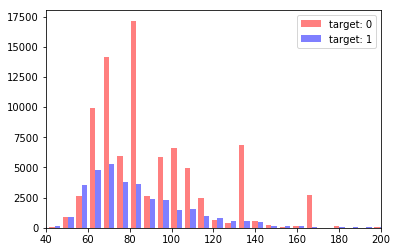

Histogram for len_paragraph
                      count       mean        std   min  median    max
len_paragraph (test)  74294  96.454667  40.660423  32.0    85.0  371.0


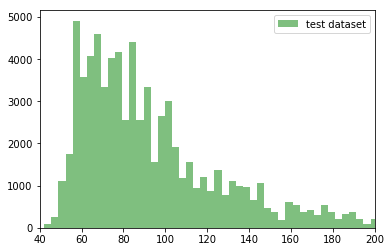

In [103]:
col_id = 0
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 40, 200, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 40, 200, test_ds, 'test')

Histogram for len_question
                          count       mean       std  min  median   max
len_question (target: 0)  85361  15.052214  6.360197  4.0    14.0  64.0
len_question (target: 1)  34037   8.577842  3.949244  2.0     8.0  60.0


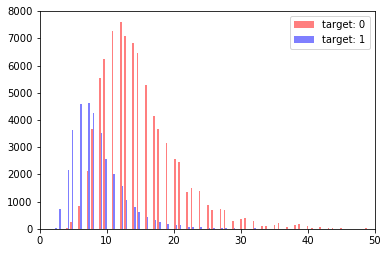

Histogram for len_question
                     count       mean       std  min  median   max
len_question (test)  74294  13.364834  6.123174  1.0    12.0  64.0


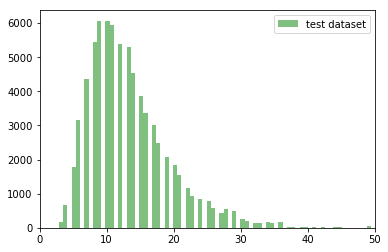

In [105]:
col_id = 1
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 50, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 50, test_ds, 'test')

Histogram for len_intersection
                              count      mean       std  min  median   max
len_intersection (target: 0)  85361  3.339078  0.705591  3.0     3.0  17.0
len_intersection (target: 1)  34037  5.697006  4.117441  0.0     5.0  58.0


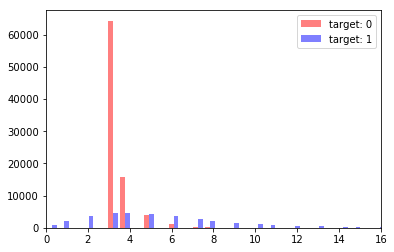

Histogram for len_intersection
                         count      mean       std  min  median   max
len_intersection (test)  74294  5.780171  3.354889  0.0     5.0  62.0


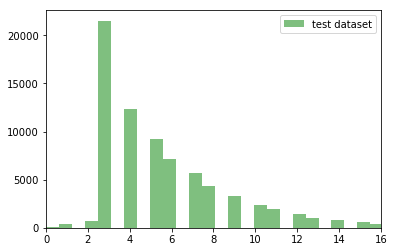

In [108]:
col_id = 2
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 16, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 16, test_ds, 'test')

Histogram for cos_dist
                      count      mean       std       min    median  max
cos_dist (target: 0)  85361  0.959705  0.070927  0.311293  0.987498  1.0
cos_dist (target: 1)  34037  0.653140  0.143093  0.008142  0.658757  1.0


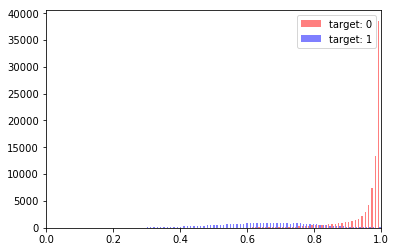

Histogram for cos_dist
                 count      mean       std      min    median  max
cos_dist (test)  74294  0.801063  0.145037  0.00975  0.830698  1.0


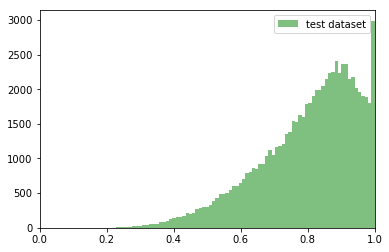

In [110]:
col_id = 3
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 1, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 1, test_ds, 'test')

Histogram for min_ratio
                       count      mean       std  min   median      max
min_ratio (target: 0)  85361  0.157075  0.058358  0.0  0.16260  0.41570
min_ratio (target: 1)  34037  0.175395  0.062424  0.0  0.17255  0.94105


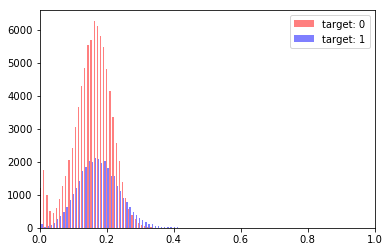

Histogram for min_ratio
                  count      mean       std  min   median      max
min_ratio (test)  74294  0.166233  0.071737  0.0  0.17167  0.93151


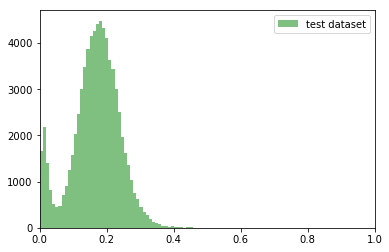

In [112]:
col_id = 4
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 1, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 1, test_ds, 'test')

Histogram for max_ratio
                       count      mean       std      min   median      max
max_ratio (target: 0)  85361  0.298720  0.080067  0.00504  0.30721  0.86179
max_ratio (target: 1)  34037  0.450915  0.176000  0.01783  0.41212  1.00000


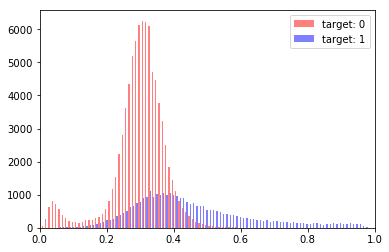

Histogram for max_ratio
                  count      mean       std  min   median  max
max_ratio (test)  74294  0.367546  0.136749  0.0  0.35573  1.0


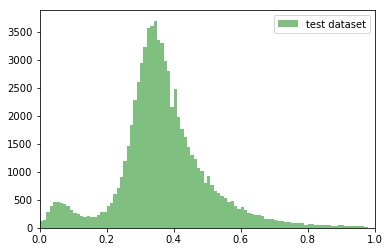

In [113]:
col_id = 5
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 1, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 1, test_ds, 'test')

Histogram for std_ratio
                       count      mean       std  min    median       max
std_ratio (target: 0)  85361  0.050828  0.023191  0.0  0.049956  0.243812
std_ratio (target: 1)  34037  0.099792  0.061595  0.0  0.085994  0.457915


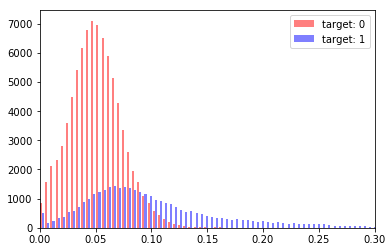

Histogram for std_ratio
                  count      mean       std  min    median       max
std_ratio (test)  74294  0.070992  0.042411  0.0  0.063735  0.420997


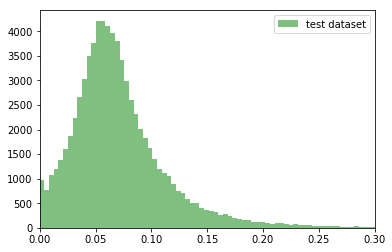

In [116]:
col_id = 6
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 0.3, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 0.3, test_ds, 'test')

Histogram for mean_ratio
                        count      mean       std       min    median  \
mean_ratio (target: 0)  85361  0.228086  0.059320  0.002520  0.237122   
mean_ratio (target: 1)  34037  0.285797  0.072611  0.011533  0.282256   

                             max  
mean_ratio (target: 0)  0.476253  
mean_ratio (target: 1)  0.941050  


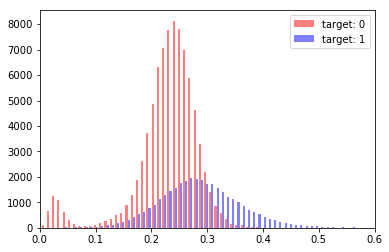

Histogram for mean_ratio
                   count      mean      std  min    median      max
mean_ratio (test)  74294  0.255084  0.08056  0.0  0.263097  0.93151


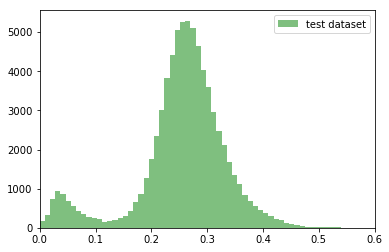

In [119]:
col_id = 7
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 0.6, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 0.6, test_ds, 'test')

Histogram for num_sentences
                           count      mean       std  min  median   max
num_sentences (target: 0)  85361  5.335868  2.137287  1.0     5.0  27.0
num_sentences (target: 1)  34037  5.102065  2.250451  1.0     5.0  42.0


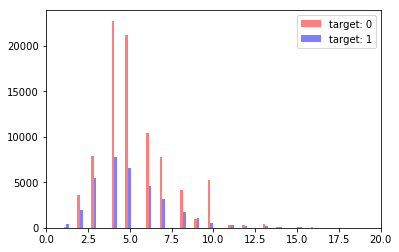

Histogram for num_sentences
                      count      mean       std  min  median   max
num_sentences (test)  74294  5.887945  2.976406  1.0     5.0  22.0


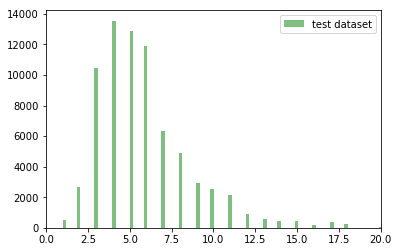

In [122]:
col_id = 8
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 20, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 20, test_ds, 'test')

Histogram for min_inter
                       count      mean       std  min  median   max
min_inter (target: 0)  85361  0.441466  0.654282  0.0     0.0   9.0
min_inter (target: 1)  34037  0.549872  1.145272  0.0     0.0  41.0


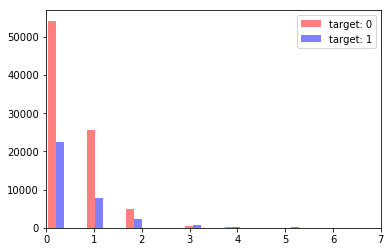

Histogram for min_inter
                  count      mean       std  min  median   max
min_inter (test)  74294  0.559776  1.045007  0.0     0.0  51.0


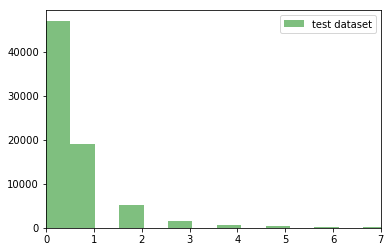

In [125]:
col_id = 9
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 7, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 7, test_ds, 'test')

Histogram for max_inter
                       count      mean       std  min  median   max
max_inter (target: 0)  85361  2.684059  0.960767  0.0     3.0  15.0
max_inter (target: 1)  34037  5.532803  3.723178  0.0     5.0  52.0


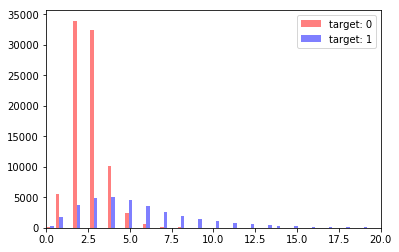

Histogram for max_inter
                  count     mean       std  min  median   max
max_inter (test)  74294  4.33424  2.537118  0.0     4.0  51.0


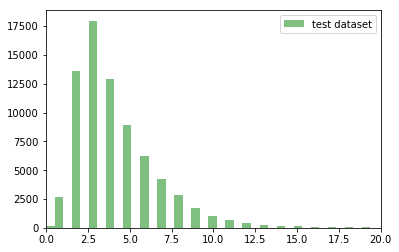

In [127]:
col_id = 10
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 20, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 20, test_ds, 'test')

Histogram for bigram_intersection
                                 count      mean       std  min  median   max
bigram_intersection (target: 0)  85361  0.053338  0.267938  0.0     0.0   7.0
bigram_intersection (target: 1)  34037  2.386550  2.876911  0.0     2.0  39.0


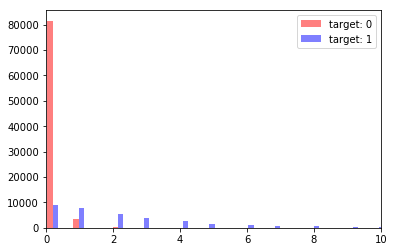

Histogram for bigram_intersection
                            count      mean       std  min  median   max
bigram_intersection (test)  74294  1.624169  2.262589  0.0     1.0  49.0


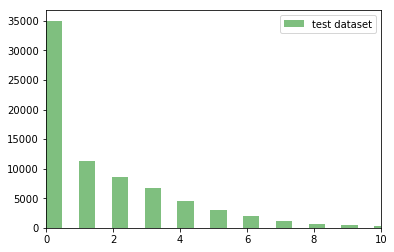

In [130]:
col_id = 11
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 10, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 10, test_ds, 'test')

Histogram for trigram_intersection
                                  count      mean       std  min  median   max
trigram_intersection (target: 0)  85361  0.005412  0.091297  0.0     0.0   4.0
trigram_intersection (target: 1)  34037  1.437906  2.569217  0.0     0.0  36.0


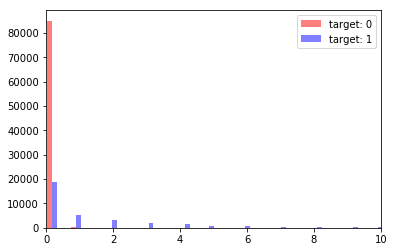

Histogram for trigram_intersection
                             count      mean       std  min  median   max
trigram_intersection (test)  74294  0.923883  1.750166  0.0     0.0  48.0


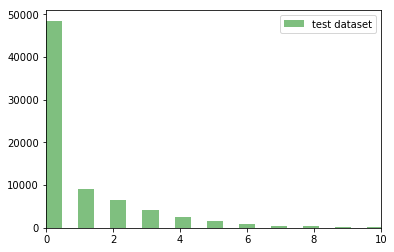

In [133]:
col_id = 12
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 10, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 10, test_ds, 'test')

Histogram for min_2g_inter
                          count      mean       std  min  median   max
min_2g_inter (target: 0)  85361  0.001617  0.045636  0.0     0.0   4.0
min_2g_inter (target: 1)  34037  0.045304  0.510550  0.0     0.0  35.0


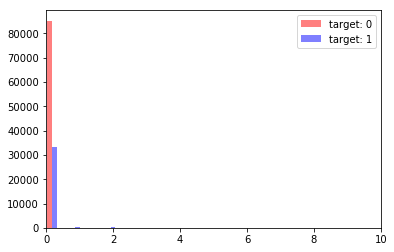

Histogram for min_2g_inter
                     count      mean       std  min  median   max
min_2g_inter (test)  74294  0.032479  0.386716  0.0     0.0  49.0


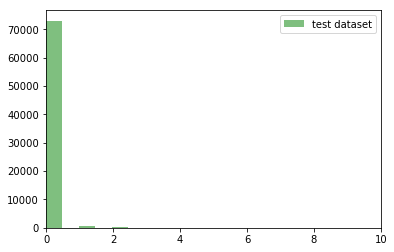

In [135]:
col_id = 13
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 10, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 10, test_ds, 'test')

Histogram for max_2g_inter
                          count      mean       std  min  median   max
max_2g_inter (target: 0)  85361  0.051675  0.257161  0.0     0.0   7.0
max_2g_inter (target: 1)  34037  2.313806  2.816797  0.0     1.0  39.0


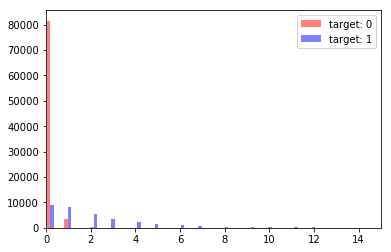

Histogram for max_2g_inter
                     count      mean       std  min  median   max
max_2g_inter (test)  74294  1.458112  2.020526  0.0     1.0  49.0


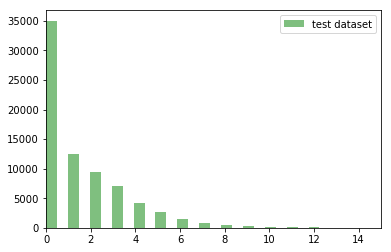

In [138]:
col_id = 14
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 15, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 15, test_ds, 'test')

Histogram for std_2g_inter
                          count      mean       std  min  median        max
std_2g_inter (target: 0)  85361  0.020580  0.104968  0.0     0.0   3.031089
std_2g_inter (target: 1)  34037  0.918621  1.148656  0.0     0.5  19.500000


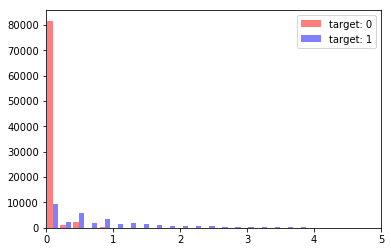

Histogram for std_2g_inter
                     count      mean       std  min    median        max
std_2g_inter (test)  74294  0.573057  0.810835  0.0  0.330719  13.422369


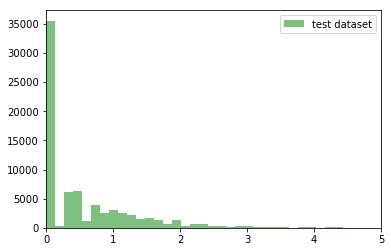

In [141]:
col_id = 15
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 5, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 5, test_ds, 'test')

Histogram for mean_2g_inter
                           count      mean       std  min    median   max
mean_2g_inter (target: 0)  85361  0.014987  0.092567  0.0  0.000000   4.0
mean_2g_inter (target: 1)  34037  0.622929  0.948188  0.0  0.333333  35.0


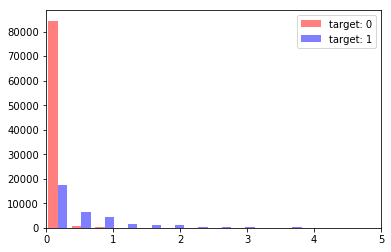

Histogram for mean_2g_inter
                      count      mean       std  min    median   max
mean_2g_inter (test)  74294  0.405731  0.710081  0.0  0.142857  49.0


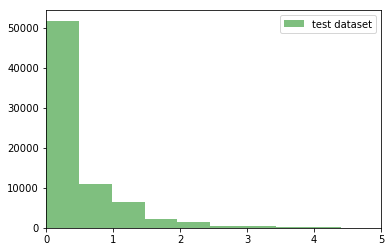

In [144]:
col_id = 16
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 5, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 5, test_ds, 'test')

Histogram for min_3g_inter
                          count      mean       std  min  median   max
min_3g_inter (target: 0)  85361  0.000141  0.012806  0.0     0.0   2.0
min_3g_inter (target: 1)  34037  0.018480  0.395771  0.0     0.0  34.0


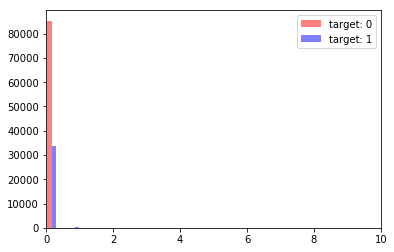

Histogram for min_3g_inter
                     count      mean       std  min  median   max
min_3g_inter (test)  74294  0.012827  0.287872  0.0     0.0  48.0


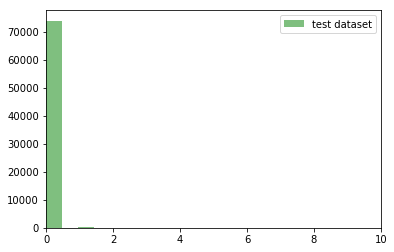

In [147]:
col_id = 17
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 10, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 10, test_ds, 'test')

Histogram for max_3g_inter
                          count      mean       std  min  median   max
max_3g_inter (target: 0)  85361  0.005319  0.089488  0.0     0.0   4.0
max_3g_inter (target: 1)  34037  1.419220  2.535555  0.0     0.0  36.0


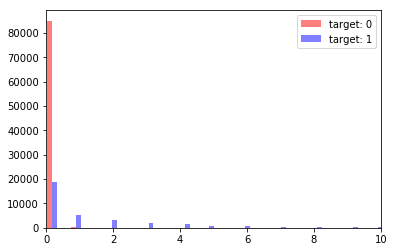

Histogram for max_3g_inter
                     count     mean       std  min  median   max
max_3g_inter (test)  74294  0.87077  1.650542  0.0     0.0  48.0


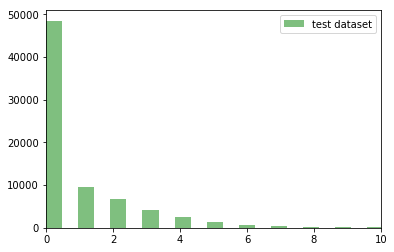

In [150]:
col_id = 18
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 10, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 10, test_ds, 'test')

Histogram for std_3g_inter
                          count      mean       std  min  median        max
std_3g_inter (target: 0)  85361  0.002193  0.038004  0.0     0.0   1.885618
std_3g_inter (target: 1)  34037  0.570850  1.044025  0.0     0.0  18.000000


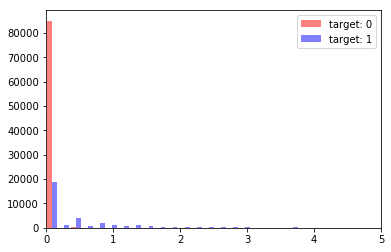

Histogram for std_3g_inter
                     count      mean       std  min  median        max
std_3g_inter (test)  74294  0.346992  0.669372  0.0     0.0  12.754084


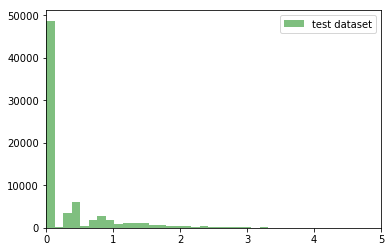

In [153]:
col_id = 19
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 5, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 5, test_ds, 'test')

Histogram for mean_3g_inter
                           count      mean       std  min  median        max
mean_3g_inter (target: 0)  85361  0.001617  0.031626  0.0     0.0   2.333333
mean_3g_inter (target: 1)  34037  0.352588  0.787968  0.0     0.0  34.000000


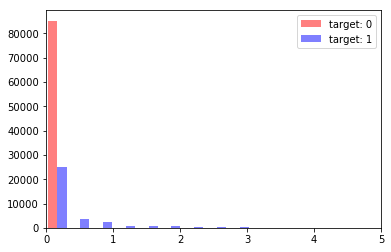

Histogram for mean_3g_inter
                      count      mean       std  min  median   max
mean_3g_inter (test)  74294  0.221854  0.528906  0.0     0.0  48.0


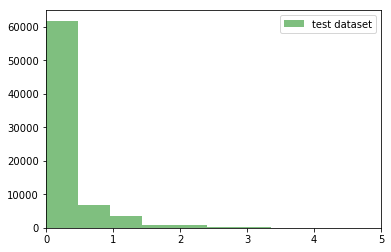

In [156]:
col_id = 20
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 5, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 5, test_ds, 'test')

Histogram for unq_qwords_rate
                             count      mean       std  min  median  max
unq_qwords_rate (target: 0)  85361  0.965489  0.048885  0.5     1.0  1.0
unq_qwords_rate (target: 1)  34037  0.990643  0.030773  0.5     1.0  1.0


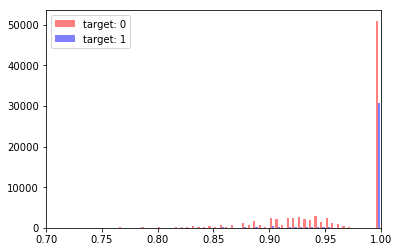

Histogram for unq_qwords_rate
                        count      mean       std       min  median  max
unq_qwords_rate (test)  74294  0.930065  0.144404  0.026316     1.0  1.0


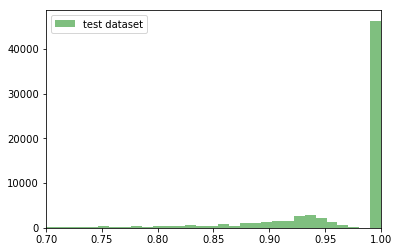

In [161]:
col_id = 21
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0.7, 1, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0.7, 1, test_ds, 'test')

Histogram for len_percent
                         count       mean        std  min   median       max
len_percent (target: 0)  85361  16.326694  10.463707  0.0  13.9130  176.9231
len_percent (target: 1)  34037   3.850301   3.263605  0.0   3.1746   90.0000


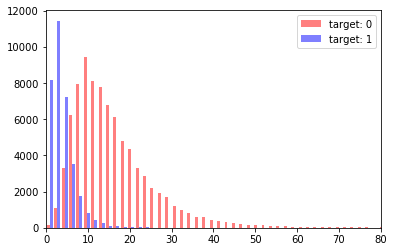

Histogram for len_percent
                    count       mean       std  min  median       max
len_percent (test)  74294  10.196423  8.218976  0.0  8.2192  227.7778


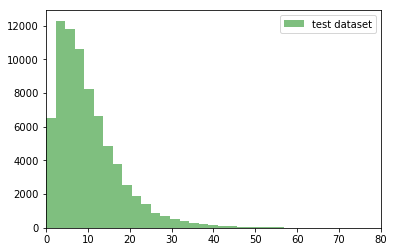

In [163]:
col_id = 22
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 80, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 80, test_ds, 'test')

Histogram for min_len_percent
                             count       mean        std  min   median  \
min_len_percent (target: 0)  85361  47.260399  29.112093  0.0  40.4762   
min_len_percent (target: 1)  34037  15.087622  10.098083  0.0  12.9032   

                                  max  
min_len_percent (target: 0)  428.5714  
min_len_percent (target: 1)  140.0000  


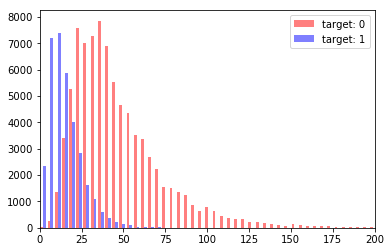

Histogram for min_len_percent
                        count       mean        std  min   median     max
min_len_percent (test)  74294  37.015169  24.840138  0.0  31.8182  293.75


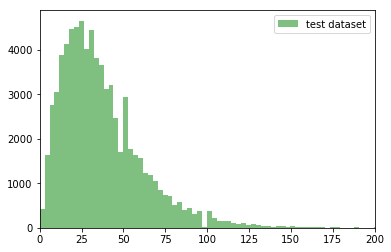

In [165]:
col_id = 23
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 200, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 200, test_ds, 'test')

Histogram for max_len_percent
                             count        mean         std     min    median  \
max_len_percent (target: 0)  85361  247.115708  366.131412  3.8462  150.0000   
max_len_percent (target: 1)  34037  102.737868  136.089642  0.0000   71.4286   

                                max  
max_len_percent (target: 0)  6100.0  
max_len_percent (target: 1)  3300.0  


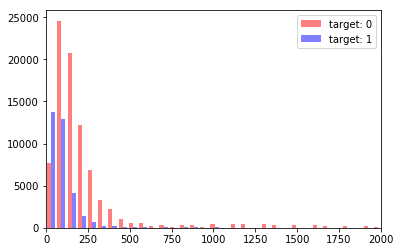

Histogram for max_len_percent
                        count     mean         std  min    median     max
max_len_percent (test)  74294  160.604  183.123625  0.0  116.6667  5000.0


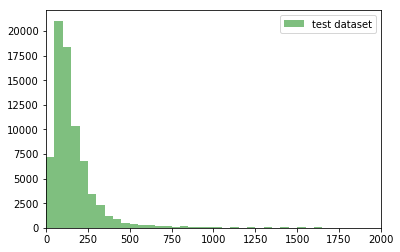

In [167]:
col_id = 24
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 2000, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 2000, test_ds, 'test')

Histogram for std_len_percent
                             count       mean         std  min     median  \
std_len_percent (target: 0)  85361  78.530417  159.428767  0.0  36.653287   
std_len_percent (target: 1)  34037  31.418710   48.752720  0.0  20.368987   

                                     max  
std_len_percent (target: 0)  3004.838700  
std_len_percent (target: 1)  1118.404856  


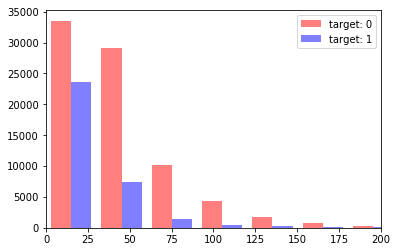

Histogram for std_len_percent
                        count       mean        std  min     median  \
std_len_percent (test)  74294  43.328603  61.713195  0.0  29.193015   

                                max  
std_len_percent (test)  1815.868858  


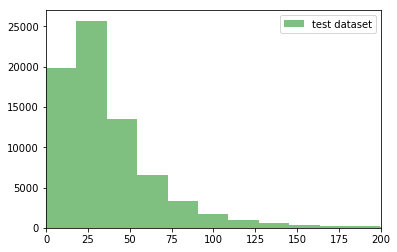

In [171]:
col_id = 25
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 200, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 200, test_ds, 'test')

Histogram for mean_len_percent
                              count        mean         std     min  \
mean_len_percent (target: 0)  85361  121.765927  133.662222  3.8462   
mean_len_percent (target: 1)  34037   49.466171   40.821304  0.0000   

                                 median        max  
mean_len_percent (target: 0)  87.858200  3095.1613  
mean_len_percent (target: 1)  40.775329  1283.6250  


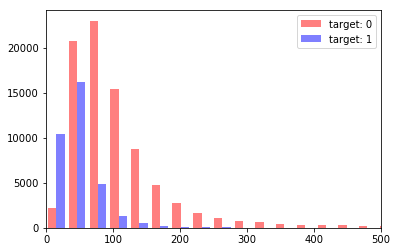

Histogram for mean_len_percent
                         count       mean        std  min    median  \
mean_len_percent (test)  74294  82.744571  58.048243  0.0  69.24038   

                                max  
mean_len_percent (test)  1396.71945  


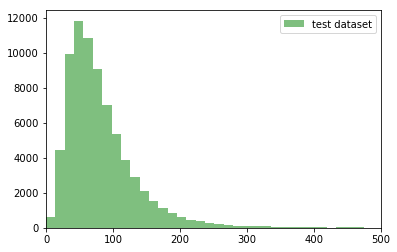

In [175]:
col_id = 26
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 500, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 500, test_ds, 'test')

Histogram for similar_perc_leven_thr_15
                                       count      mean       std  min  median  \
similar_perc_leven_thr_15 (target: 0)  85361  0.797228  0.122987  0.0  0.8333   
similar_perc_leven_thr_15 (target: 1)  34037  0.833573  0.136124  0.0  0.8333   

                                       max  
similar_perc_leven_thr_15 (target: 0)  1.0  
similar_perc_leven_thr_15 (target: 1)  1.0  


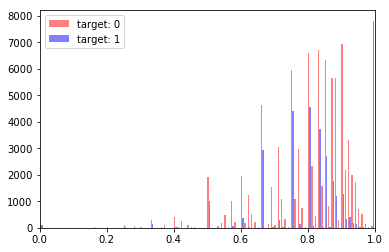

Histogram for similar_perc_leven_thr_15
                                  count      mean       std  min  median  max
similar_perc_leven_thr_15 (test)  74294  0.833801  0.112186  0.0  0.8571  1.0


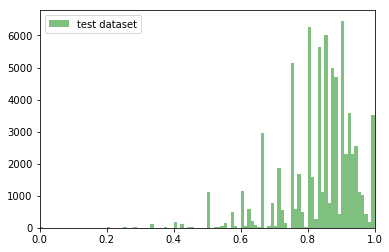

In [95]:
col_id = 27
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 1, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 1, test_ds, 'test')

Histogram for similar_perc_leven_thr_30
                                       count      mean       std  min  median  \
similar_perc_leven_thr_30 (target: 0)  85361  0.655175  0.192232  0.0  0.6667   
similar_perc_leven_thr_30 (target: 1)  34037  0.817305  0.153532  0.0  0.8333   

                                       max  
similar_perc_leven_thr_30 (target: 0)  1.0  
similar_perc_leven_thr_30 (target: 1)  1.0  


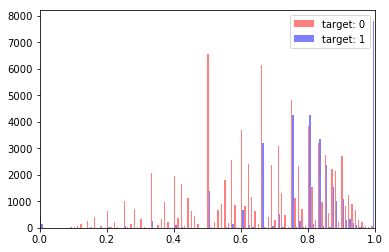

Histogram for similar_perc_leven_thr_30
                                  count      mean       std  min  median  max
similar_perc_leven_thr_30 (test)  74294  0.747644  0.166261  0.0  0.7778  1.0


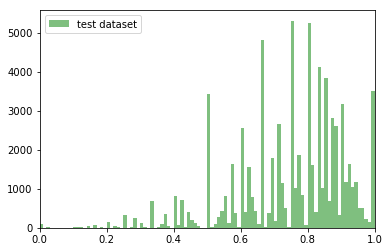

In [96]:
col_id = 28
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 1, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 1, test_ds, 'test')

Histogram for similar_perc_leven_thr_45
                                       count      mean       std  min  median  \
similar_perc_leven_thr_45 (target: 0)  85361  0.455146  0.220162  0.0  0.4444   
similar_perc_leven_thr_45 (target: 1)  34037  0.799881  0.171852  0.0  0.8182   

                                       max  
similar_perc_leven_thr_45 (target: 0)  1.0  
similar_perc_leven_thr_45 (target: 1)  1.0  


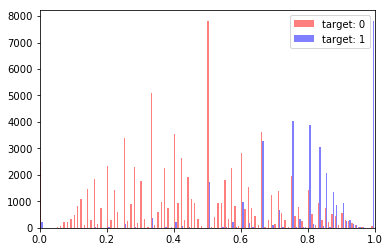

Histogram for similar_perc_leven_thr_45
                                  count      mean       std  min  median  max
similar_perc_leven_thr_45 (test)  74294  0.641012  0.212507  0.0  0.6667  1.0


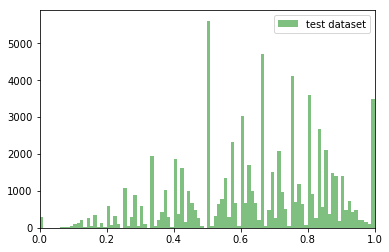

In [97]:
col_id = 29
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 1, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 1, test_ds, 'test')

Histogram for similar_perc_leven_thr_60
                                       count      mean       std  min  median  \
similar_perc_leven_thr_60 (target: 0)  85361  0.290902  0.202318  0.0    0.25   
similar_perc_leven_thr_60 (target: 1)  34037  0.781688  0.189737  0.0    0.80   

                                       max  
similar_perc_leven_thr_60 (target: 0)  1.0  
similar_perc_leven_thr_60 (target: 1)  1.0  


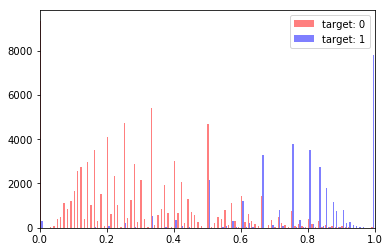

Histogram for similar_perc_leven_thr_60
                                  count      mean       std  min  median  max
similar_perc_leven_thr_60 (test)  74294  0.555752  0.244074  0.0  0.5556  1.0


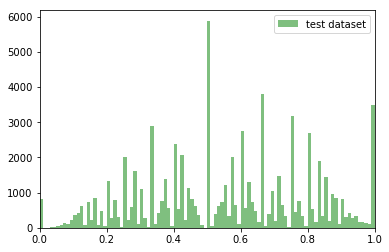

In [98]:
col_id = 30
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 1, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 1, test_ds, 'test')

Histogram for similar_perc_leven_thr_75
                                       count      mean       std  min  median  \
similar_perc_leven_thr_75 (target: 0)  85361  0.166019  0.158009  0.0  0.1333   
similar_perc_leven_thr_75 (target: 1)  34037  0.761394  0.208116  0.0  0.8000   

                                       max  
similar_perc_leven_thr_75 (target: 0)  1.0  
similar_perc_leven_thr_75 (target: 1)  1.0  


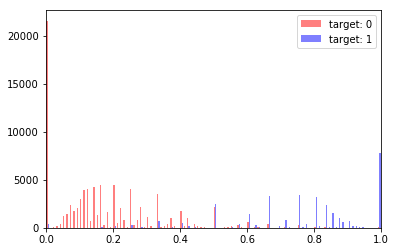

Histogram for similar_perc_leven_thr_75
                                  count      mean       std  min  median  max
similar_perc_leven_thr_75 (test)  74294  0.489135  0.267956  0.0  0.4762  1.0


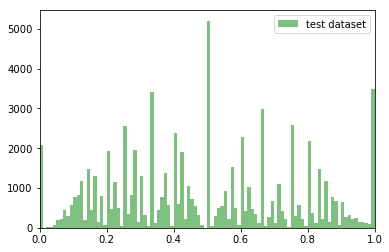

In [99]:
col_id = 31
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 1, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 1, test_ds, 'test')

Histogram for similar_perc_leven_thr_90
                                       count      mean       std  min  median  \
similar_perc_leven_thr_90 (target: 0)  85361  0.113637  0.135229  0.0   0.087   
similar_perc_leven_thr_90 (target: 1)  34037  0.731999  0.232457  0.0   0.750   

                                       max  
similar_perc_leven_thr_90 (target: 0)  1.0  
similar_perc_leven_thr_90 (target: 1)  1.0  


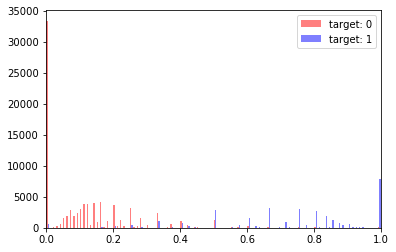

Histogram for similar_perc_leven_thr_90
                                  count      mean       std  min  median  max
similar_perc_leven_thr_90 (test)  74294  0.449906  0.278336  0.0  0.4242  1.0


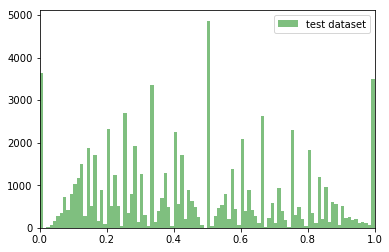

In [100]:
col_id = 32
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 1, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 1, test_ds, 'test')

Histogram for similar_perc_leven_thr_100
                                        count      mean       std  min  \
similar_perc_leven_thr_100 (target: 0)  85361  0.111231  0.134430  0.0   
similar_perc_leven_thr_100 (target: 1)  34037  0.731573  0.232933  0.0   

                                        median  max  
similar_perc_leven_thr_100 (target: 0)  0.0833  1.0  
similar_perc_leven_thr_100 (target: 1)  0.7500  1.0  


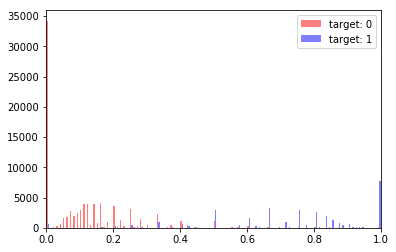

Histogram for similar_perc_leven_thr_100
                                   count      mean      std  min  median  max
similar_perc_leven_thr_100 (test)  74294  0.448172  0.27924  0.0  0.4167  1.0


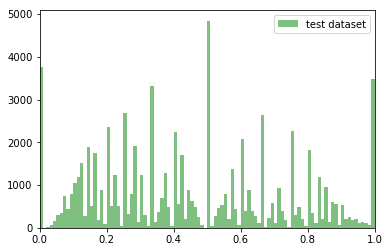

In [101]:
col_id = 33
PlotHistByTarget(train_ds[columns[col_id]], columns[col_id], 0, 1, train_ds, 'train')
PlotHistByTarget(test_ds[columns[col_id]], columns[col_id], 0, 1, test_ds, 'test')

In [180]:
max(sorted(list(train_ds.paragraph_id)))

9077

In [185]:
len(set(list(train_ds.paragraph_id)))

9078

# Models

In [204]:
columns = ['len_paragraph', # 0
           'len_question', # 1
           'len_intersection', # 2 
           'cos_dist', # 3
           #'min_ratio', # 4
           'max_ratio', # 5
           'std_ratio', # 6
           'mean_ratio', # 7 
           #'num_sentences', # 8
           #'min_inter', # 9
           'max_inter', # 10
           #'bigram_intersection', # 11
           #'trigram_intersection', # 12
           #'min_2g_inter', # 13
           #'max_2g_inter', # 14
           'std_2g_inter', # 15
           'mean_2g_inter', # 16
           #'min_3g_inter', # 17
           #'max_3g_inter', # 18
           #'std_3g_inter', # 19
           #'mean_3g_inter', # 20
           'unq_qwords_rate', # 21
           'len_percent', # 22
           #'min_len_percent', # 23 
           'max_len_percent', # 24
           'std_len_percent', # 25
           'mean_len_percent', # 26
           #'similar_perc_leven_thr_15', # 27
           #'similar_perc_leven_thr_30', # 28
           'similar_perc_leven_thr_45', # 29
           'similar_perc_leven_thr_60', # 30
           'similar_perc_leven_thr_75', # 31
           'similar_perc_leven_thr_90', # 32
           'similar_perc_leven_thr_100', # 33
           #'min_leven_list', # 34
           #'max_leven_list', # 35
           'std_leven_list', # 36
           'mean_leven_list'] # 37

### Part 1

In [ ]:
from sklearn.model_selection import train_test_split

In [223]:
import xgboost as xgb

params ={
        'eta':0.01,
        'n_estimators': 1612,
        'max_depth': 10,
        'min_child_weight': 1,
        'colsample_bytree': 0.3,
        'scale_pos_weight': 2.5,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
        }

X_train, X_valid, y_train, y_valid =train_test_split(train_ds[train_ds.num_related_pars>1].values,
                                                     train_ds[train_ds.num_related_pars>1]['target'],
                                                     test_size = 0.2)

do_validation = False

if do_validation:
    dtrain = xgb.DMatrix(X_train[columns], label = y_train)
    dvalid = xgb.DMatrix(X_valid[columns], label = y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'train(test)')]
else:
    dtrain = xgb.DMatrix(train_ds[train_ds.num_related_pars>1][columns], label = train_ds.target)
    watchlist = [(dtrain, 'train')]

%time xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=100)

dtest1 = xgb.DMatrix(test_ds[test_ds.num_related_pars>1][columns])
#preds = xgb_model.predict(dtest)

test_ds[test_ds.num_related_pars>1]['prediction'] = xgb_model.predict(dtest1,ntree_limit=xgb_model.best_iteration)

[0]	train-auc:0.993885
Will train until train-auc hasn't improved in 100 rounds.
[100]	train-auc:0.996932
[200]	train-auc:0.997767
[300]	train-auc:0.99826
[400]	train-auc:0.998685
[500]	train-auc:0.998973
[600]	train-auc:0.999201
[700]	train-auc:0.999366
[800]	train-auc:0.999502
[900]	train-auc:0.999611
[1000]	train-auc:0.999691
[1100]	train-auc:0.999752
[1200]	train-auc:0.999808
[1300]	train-auc:0.999848
[1400]	train-auc:0.99988
[1500]	train-auc:0.999904
[1600]	train-auc:0.999925
Wall time: 3min 4s


### Part 2

In [ ]:
X_train, X_valid, y_train, y_valid = split_tt(train_ds, columns, test_size = 0.2)

do_validation = False

if do_validation:
    dtrain = xgb.DMatrix(X_train[columns], label = y_train)
    dvalid = xgb.DMatrix(X_valid[columns], label = y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'train(test)')]
else:
    dtrain = xgb.DMatrix(train_ds[columns], label = train_ds.target)
    watchlist = [(dtrain, 'train')]

%time xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=100)

dtest = xgb.DMatrix(test_ds[columns])
#preds = xgb_model.predict(dtest)

test_ds['prediction'] = xgb_model.predict(dtest,ntree_limit=xgb_model.best_iteration)

In [224]:
par = []
score = []
for k in xgb_model.get_fscore():
    par.append(k)
    score.append(xgb_model.get_fscore()[k])
res = pd.DataFrame({'variable':par,'split_counts':score})
res['importance'] = res['split_counts']/res['split_counts'].sum()
res.sort_values(by='importance',ascending=False)

,split_counts,variable,importance
8,26508,std_len_percent,0.076143
4,25991,std_ratio,0.074658
19,25699,cos_dist,0.073819
20,25412,mean_len_percent,0.072995
15,25202,mean_ratio,0.072392
1,23318,len_percent,0.066980
16,23094,max_len_percent,0.066337
10,22720,max_ratio,0.065262
11,21337,len_paragraph,0.061290
17,19942,std_leven_list,0.057283


In [225]:
submit(test_ds['prediction'],'XGB_011017_4')

# XGBoost Parameters Tuning

In [260]:
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

In [248]:
from sklearn import metrics
def modelfit(alg, dtrain, columns, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[columns].values, label=dtrain['target'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[columns], dtrain['target'], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[columns])
    dtrain_predprob = alg.predict_proba(dtrain[columns])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['target'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9849
AUC Score (Train): 0.998860


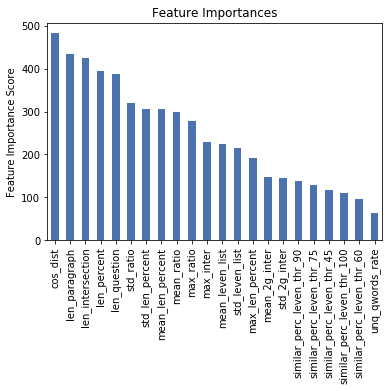

In [250]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train_ds, columns)

In [258]:
param_test1 = {
 'max_depth': [3,5,7,9],
 'min_child_weight': [1,3,5]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
%time gsearch1.fit(train_ds[columns],train_ds['target'])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.99739, std: 0.00009, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.99739, std: 0.00009, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.99740, std: 0.00009, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.99756, std: 0.00010, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.99754, std: 0.00010, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.99755, std: 0.00009, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.99759, std: 0.00010, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.99756, std: 0.00010, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.99755, std: 0.00009, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.99755, std: 0.00007, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.99755, std: 0.00009, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.99754, std: 0.00009, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_child_weight': 1

In [263]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
%time gsearch2.fit(train_ds[columns],train_ds['target'])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

Wall time: 7min 43s


([mean: 0.99750, std: 0.00010, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.99750, std: 0.00010, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.99749, std: 0.00010, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.99754, std: 0.00008, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.99755, std: 0.00009, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.99755, std: 0.00010, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.99756, std: 0.00010, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.99756, std: 0.00007, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.99755, std: 0.00008, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'max_depth': 6, 'min_child_weight': 4},
 0.9975646523867013)

## KNN

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import LMNN, NCA

In [3]:
#train_ds, test_ds = pd.read_csv("train_step7_mytokens.csv", encoding ='utf-8'), pd.read_csv("test_step7_mytokens.csv", encoding ='utf-8')
train_ds, test_ds = pd.read_csv("NA_train3.csv", encoding ='utf-8', index_col=0), pd.read_csv("NA_test3.csv", encoding ='utf-8', index_col=0)

In [4]:
train_ds.columns

Index(['paragraph_id', 'question_id', 'paragraph', 'question', 'target',
       'paragraph_uid', 'question_uid', 'list_of_paragraphs',
       'num_related_pars', 'list_ntokens_p_x', 'list_ntokens_q_x',
       'flat_list_ntokens_p', 'flat_list_ntokens_q', 'score', 'best_paragraph',
       'best_score', 'len_question_x', 'len_percent_x', 'num_sentences_x',
       'unq_qwords_rate_x', 'score_list', 'min_sent_score', 'token_set_ratio',
       'diff_score', 'len_question_y', 'len_percent_y', 'list_ntokens_p_y',
       'list_ntokens_q_y', 'num_sentences_y', 'unq_qwords_rate_y', 'cos_dist'],
      dtype='object')

In [5]:
columns1 = ['num_related_pars',
           'score',
           'best_score', 
           'len_question_x', 
           'len_percent_x', 
           'num_sentences_x',
           'unq_qwords_rate_x',
           'min_sent_score',
           'token_set_ratio',
           'diff_score',
           'cos_dist']

In [6]:
columns = ['len_paragraph', # 0
           'len_question', # 1
           'len_intersection', # 2 
           'cos_dist', # 3
           'min_ratio', # 4
           'max_ratio', # 5
           'std_ratio', # 6
           'mean_ratio', # 7 
           'num_sentences', # 8
           'min_inter', # 9
           'max_inter', # 10
           'bigram_intersection', # 11
           'trigram_intersection', # 12
           'min_2g_inter', # 13
           'max_2g_inter', # 14
           'std_2g_inter', # 15
           'mean_2g_inter', # 16
           'min_3g_inter', # 17
           'max_3g_inter', # 18
           'std_3g_inter', # 19
           'mean_3g_inter', # 20
           'unq_qwords_rate', # 21
           'len_percent', # 22
           'min_len_percent', # 23 
           'max_len_percent', # 24
           'std_len_percent', # 25
           'mean_len_percent', # 26
           'similar_perc_leven_thr_15', # 27
           'similar_perc_leven_thr_30', # 28
           'similar_perc_leven_thr_45', # 29
           'similar_perc_leven_thr_60', # 30
           'similar_perc_leven_thr_75', # 31
           'similar_perc_leven_thr_90', # 32
           'similar_perc_leven_thr_100', # 33
           'min_leven_list', # 34
           'max_leven_list', # 35
           'std_leven_list', # 36
           'mean_leven_list'] # 37

In [7]:
y_train = train_ds.target
X_train = train_ds[columns1]
X_test = test_ds[columns1]

In [8]:
X_train.columns

Index(['num_related_pars', 'score', 'best_score', 'len_question_x',
       'len_percent_x', 'num_sentences_x', 'unq_qwords_rate_x',
       'min_sent_score', 'token_set_ratio', 'diff_score', 'cos_dist'],
      dtype='object')

In [14]:
nca = NCA(max_iter=1, learning_rate=1)
nca.fit(np.array(X_train), y_train)

MemoryError: 

In [13]:
lmnn = LMNN(k=3, learn_rate=1e-6)
%time lmnn.fit(np.array(X_train), y_train)

MemoryError: 

In [298]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='auto', n_jobs=-1)
% time knn.fit(X_train, y_train)

Wall time: 457 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='distance')

In [299]:
test_ds['prediction'] = knn.predict(X_test)

In [300]:
submit(test_ds['prediction'],'KNN_101017_1')

In [301]:
#sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

In [302]:
test_ds.prediction[:7]

0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
5    1.0
6    1.0
Name: prediction, dtype: float64